# 🦴 Vertebrae Segmentation Pipeline - Kaggle Training

This notebook trains the complete 3-stage vertebrae segmentation pipeline:
1. **Stage 1**: Spine Localization (find spine center)
2. **Stage 2**: Vertebrae Localization (find each vertebra centroid)
3. **Stage 3**: Vertebrae Segmentation (segment each vertebra)

---

## 📦 1. Install Dependencies

In [73]:
# rm -rf /kaggle/working/outputs

In [1]:
# Install required packages
!pip install SimpleITK nibabel tensorboard scipy pandas --quiet

import sys
print(f"Python: {sys.version}")

import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


## 📁 2. Setup Paths and Configuration

In [2]:
import os
from pathlib import Path

# ============================================================
# CONFIGURE THESE PATHS FOR YOUR KAGGLE DATASET
# ============================================================

# Path to your dataset CSV file
# CSV should have columns: name, type, image_path, mask_path, centroid_json_path
DATASET_CSV = "/kaggle/input/verse19-csv/verse19_dataset.csv"

# Output directory for checkpoints and logs
OUTPUT_DIR = "/kaggle/working/outputs"

# Cross-validation fold to train (0-4)
FOLD = 0

# Number of epochs per stage (reduce for quick testing)
EPOCHS_STAGE1 = 50   # Spine localization
EPOCHS_STAGE2 = 100  # Vertebrae localization  
EPOCHS_STAGE3 = 50   # Vertebrae segmentation

# Batch sizes (adjust based on GPU memory)
BATCH_SIZE_STAGE1 = 2
BATCH_SIZE_STAGE2 = 1
BATCH_SIZE_STAGE3 = 2

# ============================================================
# 🧪 QUICK TEST MODE - Set to None to use full dataset
# ============================================================
# Set to a small number (e.g., 3, 5, 10) to test pipeline quickly
# Set to None to use full dataset
QUICK_TEST_SAMPLES = 10  # <-- CHANGE THIS (None for full dataset)

# If quick test is enabled, reduce epochs
if QUICK_TEST_SAMPLES is not None:
    EPOCHS_STAGE1 = 10
    EPOCHS_STAGE2 = 10
    EPOCHS_STAGE3 = 10
    print(f"⚠️ QUICK TEST MODE: Using only {QUICK_TEST_SAMPLES} samples")
    print(f"   Epochs reduced to {EPOCHS_STAGE1} per stage")

# ============================================================

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"Dataset CSV: {DATASET_CSV}")
print(f"Training fold: {FOLD}")

⚠️ QUICK TEST MODE: Using only 10 samples
   Epochs reduced to 10 per stage

Output directory: /kaggle/working/outputs
Dataset CSV: /kaggle/input/verse19-csv/verse19_dataset.csv
Training fold: 0


## 📊 3. Load and Inspect Dataset

In [3]:
import pandas as pd
import os

# Load dataset
df = pd.read_csv(DATASET_CSV)
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nSample types: {df['type'].value_counts().to_dict() if 'type' in df.columns else 'N/A'}")

# ============================================================
# 🔍 DATA VALIDATION - Check for missing/invalid paths
# ============================================================
print("\n" + "="*60)
print("DATA VALIDATION")
print("="*60)

original_count = len(df)

# Check for NaN values in critical columns
required_columns = ['image_path', 'mask_path', 'centroid_json_path']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"❌ ERROR: Missing required columns: {missing_columns}")
    print(f"   Available columns: {list(df.columns)}")
    raise ValueError(f"CSV must have columns: {required_columns}")

# Check for NaN/null values
print(f"\nChecking for missing values...")
for col in required_columns:
    null_count = df[col].isna().sum()
    if null_count > 0:
        print(f"  ⚠️ {col}: {null_count} missing values")
        # Show which rows have missing values
        missing_rows = df[df[col].isna()]['name'].tolist() if 'name' in df.columns else df[df[col].isna()].index.tolist()
        print(f"     Missing in: {missing_rows[:5]}{'...' if len(missing_rows) > 5 else ''}")

# Remove rows with any NaN values in required columns
df_clean = df.dropna(subset=required_columns).reset_index(drop=True)
removed_count = original_count - len(df_clean)

if removed_count > 0:
    print(f"\n⚠️ REMOVED {removed_count} rows with missing paths")
    print(f"   Original: {original_count} samples")
    print(f"   Clean: {len(df_clean)} samples")
    df = df_clean
else:
    print(f"\n✅ All {len(df)} samples have valid paths")

# Optional: Check if files actually exist (only for first few samples to avoid slow checks)
print(f"\nValidating first 3 samples...")
for idx in range(min(3, len(df))):
    row = df.iloc[idx]
    name = row.get('name', f'sample_{idx}')
    
    img_exists = os.path.exists(row['image_path'])
    mask_exists = os.path.exists(row['mask_path'])
    json_exists = os.path.exists(row['centroid_json_path'])
    
    if img_exists and mask_exists and json_exists:
        print(f"  ✅ {name}: All files exist")
    else:
        print(f"  ⚠️ {name}:")
        if not img_exists:
            print(f"     - Image missing: {row['image_path']}")
        if not mask_exists:
            print(f"     - Mask missing: {row['mask_path']}")
        if not json_exists:
            print(f"     - JSON missing: {row['centroid_json_path']}")

print("="*60)
print(f"\n✅ Final dataset: {len(df)} valid samples")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (151, 5)

Columns: ['name', 'type', 'image_path', 'mask_path', 'centroid_json_path']

Sample types: {'train': 76, 'validation': 38, 'test': 37}

DATA VALIDATION

Checking for missing values...
  ⚠️ mask_path: 1 missing values
     Missing in: ['verse012']

⚠️ REMOVED 1 rows with missing paths
   Original: 151 samples
   Clean: 150 samples

Validating first 3 samples...
  ✅ verse004: All files exist
  ✅ verse006: All files exist
  ✅ verse007: All files exist

✅ Final dataset: 150 valid samples

First 5 rows:


,name,type,image_path,mask_path,centroid_json_path
0,verse004,train,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...
1,verse006,train,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...
2,verse007,train,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...
3,verse008,train,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...
4,verse009,train,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...,/kaggle/input/verse-19-3d-images/dataset-verse...


In [4]:
# ============================================================
# Helper Functions for Centroid JSON Parsing
# ============================================================

import json
import numpy as np
from typing import Dict, List, Optional, Tuple

# Label mapping: VerSe uses integer labels for vertebrae
LABEL_TO_VERTEBRA = {
    1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7',
    8: 'T1', 9: 'T2', 10: 'T3', 11: 'T4', 12: 'T5', 13: 'T6',
    14: 'T7', 15: 'T8', 16: 'T9', 17: 'T10', 18: 'T11', 19: 'T12',
    20: 'L1', 21: 'L2', 22: 'L3', 23: 'L4', 24: 'L5', 25: 'L6',
    26: 'S1', 27: 'S2', 28: 'Sacrum'
}

VERTEBRA_TO_LABEL = {v: k for k, v in LABEL_TO_VERTEBRA.items()}


def parse_centroid_json(json_path: str) -> Tuple[Dict[str, np.ndarray], Optional[List[str]]]:
    """
    Parse VerSe centroid JSON file.
    
    VerSe Format:
    [
        {"direction": ["P", "I", "R"]},  # Optional first entry
        {"label": 17, "X": 94.8, "Y": 46.1, "Z": 19.1},
        {"label": 18, "X": 95.2, "Y": 83.5, "Z": 22.3},
        ...
    ]
    
    Returns:
        centroids (dict): Maps vertebra name to [Z, Y, X] coordinates in mm
                         Also includes '{name}_label' keys with integer labels
        direction (list): Direction array from JSON (e.g., ["P", "I", "R"]) or None
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    if not isinstance(data, list):
        raise ValueError(f"Expected list format, got {type(data)}")
    
    centroids = {}
    direction = None
    
    for entry in data:
        if not isinstance(entry, dict):
            continue
            
        # Check if this is the direction entry
        if 'direction' in entry:
            direction = entry['direction']
            continue
        
        # Parse vertebra entry
        if 'label' in entry and 'X' in entry and 'Y' in entry and 'Z' in entry:
            label = entry['label']
            x = float(entry['X'])
            y = float(entry['Y'])
            z = float(entry['Z'])
            
            # Get vertebra name from label
            vertebra_name = LABEL_TO_VERTEBRA.get(label, f'Unknown_{label}')
            
            # Store coordinates as [Z, Y, X] (SimpleITK convention)
            centroids[vertebra_name] = np.array([z, y, x], dtype=np.float32)
            centroids[f'{vertebra_name}_label'] = label
    
    return centroids, direction


def get_vertebra_name(label: int) -> str:
    """Convert integer label to vertebra name (e.g., 17 -> 'T10')"""
    return LABEL_TO_VERTEBRA.get(label, f'Unknown_{label}')


def get_vertebra_label(name: str) -> Optional[int]:
    """Convert vertebra name to integer label (e.g., 'T10' -> 17)"""
    return VERTEBRA_TO_LABEL.get(name)


print("✅ Centroid parsing functions loaded")
print(f"   Label mapping: {len(LABEL_TO_VERTEBRA)} vertebrae")
print(f"   Range: C1-C7, T1-T12, L1-L6, S1-S2, Sacrum")

✅ Centroid parsing functions loaded
   Label mapping: 28 vertebrae
   Range: C1-C7, T1-T12, L1-L6, S1-S2, Sacrum


In [5]:
# ============================================================
# Test Centroid JSON Parsing
# ============================================================
# Verify that the centroid files can be parsed correctly

print("Testing centroid JSON parsing...")
test_row = df.iloc[0]
print(f"Testing file: {test_row['centroid_json_path']}")

try:
    centroids, direction = parse_centroid_json(test_row['centroid_json_path'])
    print(f"✅ Successfully parsed centroid file!")
    print(f"   Direction: {direction}")
    print(f"   Found {len([k for k in centroids.keys() if '_label' not in k])} vertebrae:")
    for vert_name, coords in centroids.items():
        if '_label' not in vert_name:
            label = centroids.get(f'{vert_name}_label', '?')
            print(f"     {vert_name} (label={label}): Z={coords[0]:.1f}, Y={coords[1]:.1f}, X={coords[2]:.1f} mm")
except Exception as e:
    print(f"❌ Error parsing centroid file: {e}")
    print("Please check the JSON format!")

Testing centroid JSON parsing...
Testing file: /kaggle/input/verse-19-3d-images/dataset-verse19training/derivatives/sub-verse004/sub-verse004_seg-vb_ctd.json
✅ Successfully parsed centroid file!
   Direction: ['P', 'I', 'R']
   Found 9 vertebrae:
     T9 (label=16): Z=31.9, Y=40.6, X=79.4 mm
     T10 (label=17): Z=31.8, Y=63.1, X=79.4 mm
     T11 (label=18): Z=31.6, Y=88.8, X=76.2 mm
     T12 (label=19): Z=31.1, Y=117.3, X=70.8 mm
     L1 (label=20): Z=31.1, Y=141.0, X=63.4 mm
     L2 (label=21): Z=30.3, Y=167.7, X=53.0 mm
     L3 (label=22): Z=29.3, Y=202.1, X=46.6 mm
     L4 (label=23): Z=28.5, Y=235.2, X=46.8 mm
     L5 (label=24): Z=28.7, Y=266.5, X=57.4 mm


In [6]:
# Split into train/val for the current fold
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

train_indices, val_indices = list(kf.split(df))[FOLD]
train_df = df.iloc[train_indices].reset_index(drop=True)
val_df = df.iloc[val_indices].reset_index(drop=True)

# Apply quick test limit if enabled
if QUICK_TEST_SAMPLES is not None:
    train_df = train_df.head(QUICK_TEST_SAMPLES).reset_index(drop=True)
    val_df = val_df.head(max(1, QUICK_TEST_SAMPLES // 2)).reset_index(drop=True)
    print(f"⚠️ QUICK TEST: Limited to {len(train_df)} train, {len(val_df)} val samples")

print(f"Fold {FOLD}: {len(train_df)} training, {len(val_df)} validation samples")

⚠️ QUICK TEST: Limited to 10 train, 5 val samples
Fold 0: 10 training, 5 validation samples


---
## 🧪 Pipeline Verification Test

Before training, let's verify all components work correctly with a single sample.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import SimpleITK as sitk
import json
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# ============================================================
# Stage 1 Configuration
# ============================================================
class Stage1Config:
    image_size = (64, 64, 128)  # D, H, W
    spacing = (8.0, 8.0, 8.0)   # mm
    num_filters_base = 32
    num_levels = 4
    heatmap_sigma = 4.0
    learning_rate = 1e-4
    
config1 = Stage1Config()
print("Stage 1 Config loaded")

Stage 1 Config loaded


In [8]:
# ============================================================
# Utility Functions
# ============================================================

def load_image(path):
    """Load a medical image using SimpleITK."""
    image = sitk.ReadImage(str(path))
    return image

def resample_image(image, new_spacing, new_size=None, interpolator=sitk.sitkLinear):
    """Resample image to new spacing."""
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    
    if new_size is None:
        new_size = [
            int(round(osz * ospc / nspc))
            for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)
        ]
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetInterpolator(interpolator)
    resampler.SetDefaultPixelValue(float(np.min(sitk.GetArrayFromImage(image))))
    
    return resampler.Execute(image)

def normalize_intensity(array, window_min=-1000, window_max=1500):
    """Normalize CT intensity to [0, 1]."""
    array = np.clip(array, window_min, window_max)
    array = (array - window_min) / (window_max - window_min)
    return array.astype(np.float32)

def generate_heatmap(shape, centroid, sigma):
    """Generate Gaussian heatmap at centroid location."""
    heatmap = np.zeros(shape, dtype=np.float32)
    if centroid is not None:
        # Round to nearest voxel
        z, y, x = [int(round(c)) for c in centroid]
        if 0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]:
            heatmap[z, y, x] = 1.0
            heatmap = gaussian_filter(heatmap, sigma=sigma)
            if heatmap.max() > 0:
                heatmap /= heatmap.max()
    return heatmap

def compute_centroid_from_mask(mask_array):
    """Compute centroid from binary mask."""
    coords = np.where(mask_array > 0)
    if len(coords[0]) == 0:
        return None
    centroid = [np.mean(c) for c in coords]
    return centroid

print("✅ Utility functions loaded")

✅ Utility functions loaded


In [9]:
# ============================================================
# U-Net 3D Model
# ============================================================

class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_filters=32, num_levels=4):
        super().__init__()
        self.num_levels = num_levels
        
        # Encoder
        self.encoders = nn.ModuleList()
        self.pools = nn.ModuleList()
        
        channels = in_channels
        for i in range(num_levels):
            out_ch = base_filters * (2 ** i)
            self.encoders.append(ConvBlock3D(channels, out_ch))
            if i < num_levels - 1:
                self.pools.append(nn.MaxPool3d(2))
            channels = out_ch
        
        # Decoder
        self.upconvs = nn.ModuleList()
        self.decoders = nn.ModuleList()
        
        for i in range(num_levels - 2, -1, -1):
            in_ch = base_filters * (2 ** (i + 1))
            out_ch = base_filters * (2 ** i)
            self.upconvs.append(nn.ConvTranspose3d(in_ch, out_ch, 2, stride=2))
            self.decoders.append(ConvBlock3D(in_ch, out_ch))
        
        # Output
        self.out_conv = nn.Conv3d(base_filters, out_channels, 1)
    
    def forward(self, x):
        # Encoder path
        enc_features = []
        for i, encoder in enumerate(self.encoders):
            x = encoder(x)
            if i < self.num_levels - 1:
                enc_features.append(x)
                x = self.pools[i](x)
        
        # Decoder path
        for i, (upconv, decoder) in enumerate(zip(self.upconvs, self.decoders)):
            x = upconv(x)
            skip = enc_features[-(i + 1)]
            # Handle size mismatch
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:], mode='trilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
            x = decoder(x)
        
        return self.out_conv(x)

# Test model
model_test = UNet3D(1, 1, 32, 4)
x_test = torch.randn(1, 1, 64, 64, 128)
y_test = model_test(x_test)
print(f"UNet3D test - Input: {x_test.shape}, Output: {y_test.shape}")
del model_test, x_test, y_test
torch.cuda.empty_cache()

UNet3D test - Input: torch.Size([1, 1, 64, 64, 128]), Output: torch.Size([1, 1, 64, 64, 128])


In [10]:
# ============================================================
# Stage 1 Dataset
# ============================================================

class SpineLocalizationDataset(Dataset):
    def __init__(self, dataframe, config, augment=False):
        self.df = dataframe
        self.config = config
        self.augment = augment
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        image = load_image(row['image_path'])
        
        # Resample to target spacing
        target_spacing = self.config.spacing
        image = resample_image(image, target_spacing)
        
        # Get array and normalize
        image_array = sitk.GetArrayFromImage(image)  # (D, H, W)
        image_array = normalize_intensity(image_array)
        
        # Pad or crop to target size
        image_array = self._resize_to_target(image_array, self.config.image_size)
        
        # Load mask and compute spine centroid
        mask = load_image(row['mask_path'])
        mask = resample_image(mask, target_spacing, interpolator=sitk.sitkNearestNeighbor)
        mask_array = sitk.GetArrayFromImage(mask)
        mask_array = self._resize_to_target(mask_array, self.config.image_size)
        
        # Compute centroid from mask
        centroid = compute_centroid_from_mask(mask_array)
        
        # Generate heatmap
        heatmap = generate_heatmap(
            self.config.image_size,
            centroid,
            self.config.heatmap_sigma
        )
        
        # Convert to tensors
        image_tensor = torch.from_numpy(image_array).unsqueeze(0).float()  # (1, D, H, W)
        heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0).float()    # (1, D, H, W)
        
        return {
            'image': image_tensor,
            'heatmap': heatmap_tensor,
            'name': row['name']
        }
    
    def _resize_to_target(self, array, target_size):
        """Pad or crop array to target size."""
        result = np.zeros(target_size, dtype=array.dtype)
        
        # Compute copy ranges
        src_slices = []
        dst_slices = []
        for i in range(3):
            src_size = array.shape[i]
            dst_size = target_size[i]
            if src_size >= dst_size:
                # Crop from center
                start = (src_size - dst_size) // 2
                src_slices.append(slice(start, start + dst_size))
                dst_slices.append(slice(0, dst_size))
            else:
                # Pad
                start = (dst_size - src_size) // 2
                src_slices.append(slice(0, src_size))
                dst_slices.append(slice(start, start + src_size))
        
        result[dst_slices[0], dst_slices[1], dst_slices[2]] = \
            array[src_slices[0], src_slices[1], src_slices[2]]
        
        return result

print("SpineLocalizationDataset defined")

SpineLocalizationDataset defined


In [11]:
# ============================================================
# Training Function
# ============================================================

def train_epoch(model, loader, optimizer, criterion, device, desc="Training"):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc=desc)
    for batch in pbar:
        images = batch['image'].to(device)
        targets = batch['heatmap'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

def validate_epoch(model, loader, criterion, device, desc="Validation"):
    model.eval()
    total_loss = 0
    all_errors = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc=desc)
        for batch in pbar:
            images = batch['image'].to(device)
            targets = batch['heatmap'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Compute localization error
            for i in range(outputs.shape[0]):
                pred_heatmap = outputs[i, 0].cpu().numpy()
                gt_heatmap = targets[i, 0].cpu().numpy()
                
                # Find peak
                pred_idx = np.unravel_index(np.argmax(pred_heatmap), pred_heatmap.shape)
                gt_idx = np.unravel_index(np.argmax(gt_heatmap), gt_heatmap.shape)
                
                # Error in mm (multiply by spacing)
                error = np.sqrt(sum(
                    ((p - g) * s) ** 2 
                    for p, g, s in zip(pred_idx, gt_idx, config1.spacing)
                ))
                all_errors.append(error)
    
    mean_error = np.mean(all_errors) if all_errors else 0
    return total_loss / len(loader), mean_error

print("Training functions defined")

Training functions defined


In [12]:
# ============================================================
# Stage 3 Training Functions (Segmentation)
# ============================================================
# Stage 3 uses 'mask' instead of 'heatmap' and computes Dice score

def train_stage3_epoch(model, loader, optimizer, criterion, device, desc="Training"):
    """Training loop for Stage 3 (Vertebrae Segmentation)"""
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc=desc)
    for batch in pbar:
        images = batch['image'].to(device)
        targets = batch['mask'].to(device)  # <-- Use 'mask' not 'heatmap'
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)


def validate_stage3(model, loader, criterion, device):
    """Validation loop for Stage 3 with Dice score computation"""
    model.eval()
    total_loss = 0
    dice_scores = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for batch in pbar:
            images = batch['image'].to(device)
            targets = batch['mask'].to(device)  # <-- Use 'mask' not 'heatmap'
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Compute Dice score
            preds = torch.sigmoid(outputs) > 0.5
            for i in range(preds.shape[0]):
                pred_mask = preds[i, 0].float()
                target_mask = targets[i, 0].float()
                
                intersection = (pred_mask * target_mask).sum()
                union = pred_mask.sum() + target_mask.sum()
                
                if union > 0:
                    dice = (2.0 * intersection / union).item()
                    dice_scores.append(dice)
            
            if dice_scores:
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{np.mean(dice_scores):.4f}'})
    
    mean_dice = np.mean(dice_scores) if dice_scores else 0.0
    return total_loss / len(loader), mean_dice


print("✅ Stage 3 training functions defined (uses 'mask' instead of 'heatmap')")

✅ Stage 3 training functions defined (uses 'mask' instead of 'heatmap')


In [13]:
# ============================================================
# Train Stage 1: Spine Localization
# ============================================================

print("="*60)
print("STAGE 1: SPINE LOCALIZATION")
print("="*60)

# Create datasets
train_dataset_s1 = SpineLocalizationDataset(train_df, config1, augment=True)
val_dataset_s1 = SpineLocalizationDataset(val_df, config1, augment=False)

train_loader_s1 = DataLoader(train_dataset_s1, batch_size=BATCH_SIZE_STAGE1, shuffle=True, num_workers=2)
val_loader_s1 = DataLoader(val_dataset_s1, batch_size=BATCH_SIZE_STAGE1, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset_s1)}")
print(f"Validation samples: {len(val_dataset_s1)}")

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_s1 = UNet3D(in_channels=1, out_channels=1, base_filters=config1.num_filters_base, num_levels=config1.num_levels)
model_s1 = nn.DataParallel(model_s1)
model_s1 = model_s1.to(device)

# Loss and optimizer
criterion_s1 = nn.MSELoss()
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=config1.learning_rate)
scheduler_s1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_s1, mode='min', patience=5, factor=0.5)

# Training history
history_s1 = {'train_loss': [], 'val_loss': [], 'val_error': []}

print(f"\nStarting training on {device}...")

STAGE 1: SPINE LOCALIZATION
Training samples: 10
Validation samples: 5

Starting training on cuda...


In [14]:
# Training loop for Stage 1
best_val_loss_s1 = float('inf')
stage1_checkpoint = os.path.join(OUTPUT_DIR, 'stage1_best.pth')

for epoch in range(EPOCHS_STAGE1):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE1}")
    
    # Train
    train_loss = train_epoch(model_s1, train_loader_s1, optimizer_s1, criterion_s1, device, f"Train [{epoch+1}]")
    
    # Validate
    val_loss, val_error = validate_epoch(model_s1, val_loader_s1, criterion_s1, device, f"Val [{epoch+1}]")
    
    # Update scheduler
    scheduler_s1.step(val_loss)
    
    # Save history
    history_s1['train_loss'].append(train_loss)
    history_s1['val_loss'].append(val_loss)
    history_s1['val_error'].append(val_error)
    
    print(f"  Train Loss: {train_loss:.6f}")
    print(f"  Val Loss: {val_loss:.6f}")
    print(f"  Val Error: {val_error:.2f} mm")
    
    # Save best model
    if val_loss < best_val_loss_s1:
        best_val_loss_s1 = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_s1.state_dict(),
            'optimizer_state_dict': optimizer_s1.state_dict(),
            'val_loss': val_loss,
            'val_error': val_error
        }, stage1_checkpoint)
        print(f"  ✓ Saved best model (loss: {val_loss:.6f})")

print(f"\n✅ Stage 1 training complete!")
print(f"Best validation loss: {best_val_loss_s1:.6f}")


Epoch 1/10


Train [1]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [1]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.122520
  Val Loss: 0.005747
  Val Error: 602.09 mm
  ✓ Saved best model (loss: 0.005747)

Epoch 2/10


Train [2]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [2]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.051302
  Val Loss: 0.001091
  Val Error: 456.48 mm
  ✓ Saved best model (loss: 0.001091)

Epoch 3/10


Train [3]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [3]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.033233
  Val Loss: 0.001572
  Val Error: 454.44 mm

Epoch 4/10


Train [4]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [4]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.024155
  Val Loss: 0.003341
  Val Error: 453.14 mm

Epoch 5/10


Train [5]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [5]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.018166
  Val Loss: 0.003197
  Val Error: 148.68 mm

Epoch 6/10


Train [6]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [6]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.014740
  Val Loss: 0.003670
  Val Error: 168.92 mm

Epoch 7/10


Train [7]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [7]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.012507
  Val Loss: 0.002469
  Val Error: 168.21 mm

Epoch 8/10


Train [8]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [8]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.010201
  Val Loss: 0.002924
  Val Error: 162.27 mm

Epoch 9/10


Train [9]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [9]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.009201
  Val Loss: 0.003404
  Val Error: 152.03 mm

Epoch 10/10


Train [10]:   0%|          | 0/5 [00:00<?, ?it/s]

Val [10]:   0%|          | 0/3 [00:00<?, ?it/s]

  Train Loss: 0.008634
  Val Loss: 0.003602
  Val Error: 162.32 mm

✅ Stage 1 training complete!
Best validation loss: 0.001091


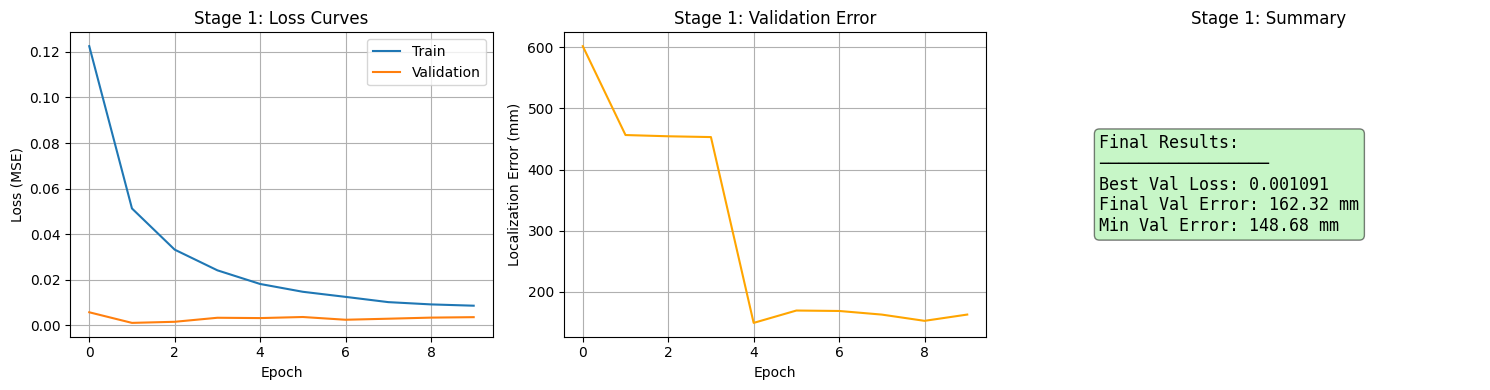


📊 Stage 1 results saved to /kaggle/working/outputs/stage1_results.png


In [15]:
# Plot Stage 1 Results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history_s1['train_loss'], label='Train')
axes[0].plot(history_s1['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Stage 1: Loss Curves')
axes[0].legend()
axes[0].grid(True)

# Localization error
axes[1].plot(history_s1['val_error'], color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Localization Error (mm)')
axes[1].set_title('Stage 1: Validation Error')
axes[1].grid(True)

# Final metrics
metrics_text = f"""Final Results:
─────────────────
Best Val Loss: {best_val_loss_s1:.6f}
Final Val Error: {history_s1['val_error'][-1]:.2f} mm
Min Val Error: {min(history_s1['val_error']):.2f} mm"""
axes[2].text(0.1, 0.5, metrics_text, transform=axes[2].transAxes, fontsize=12, 
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[2].axis('off')
axes[2].set_title('Stage 1: Summary')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage1_results.png'), dpi=150)
plt.show()

print(f"\n📊 Stage 1 results saved to {OUTPUT_DIR}/stage1_results.png")

---
# 🎯 Stage 2: Vertebrae Localization

Locate individual vertebrae centroids within the spine region.
- **Input**: Cropped CT around spine (2mm spacing, 96×96×128)
- **Output**: 26 heatmaps (one per vertebra: C1-C7, T1-T12, L1-L6, S1)
- **Network**: Spatial Configuration Net (SCNet)

In [16]:
# ============================================================
# Stage 2 Configuration
# ============================================================
class Stage2Config:
    image_size = (96, 96, 128)  # D, H, W
    spacing = (2.0, 2.0, 2.0)   # mm
    num_landmarks = 26          # C1-C7, T1-T12, L1-L6, S1
    num_filters_base = 64
    heatmap_sigma = 3.0
    learning_rate = 1e-4
    
    # Vertebra labels
    vertebra_labels = (
        ['C' + str(i) for i in range(1, 8)] +    # C1-C7
        ['T' + str(i) for i in range(1, 13)] +   # T1-T12
        ['L' + str(i) for i in range(1, 7)] +    # L1-L6
        ['S1']                                    # S1
    )

config2 = Stage2Config()
print(f"Stage 2 Config loaded")
print(f"Vertebra labels: {config2.vertebra_labels}")

Stage 2 Config loaded
Vertebra labels: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'S1']


In [17]:
# ============================================================
# Spatial Configuration Network (SCNet)
# ============================================================

class LocalAppearanceNetwork(nn.Module):
    """Processes local appearance for each landmark."""
    def __init__(self, in_channels=1, num_landmarks=26, base_filters=64):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, base_filters, 3, padding=1),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(base_filters, base_filters, 3, padding=1),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(base_filters, base_filters, 3, padding=1),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Conv3d(base_filters, num_landmarks, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.out(x)

class SpatialConfigurationNetwork(nn.Module):
    """Processes spatial relationships between landmarks."""
    def __init__(self, num_landmarks=26, base_filters=64):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(num_landmarks, base_filters, 3, padding=1),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Sequential(
            nn.Conv3d(base_filters, base_filters * 2, 3, padding=1),
            nn.BatchNorm3d(base_filters * 2),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Sequential(
            nn.Conv3d(base_filters * 2, base_filters * 2, 3, padding=1),
            nn.BatchNorm3d(base_filters * 2),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False)
        self.conv4 = nn.Sequential(
            nn.Conv3d(base_filters * 2, base_filters, 3, padding=1),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False)
        self.out = nn.Conv3d(base_filters, num_landmarks, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.up1(x)
        x = self.conv4(x)
        x = self.up2(x)
        return self.out(x)

class SCNet(nn.Module):
    """Combined Local Appearance + Spatial Configuration Network."""
    def __init__(self, in_channels=1, num_landmarks=26, base_filters=64):
        super().__init__()
        self.local_net = LocalAppearanceNetwork(in_channels, num_landmarks, base_filters)
        self.spatial_net = SpatialConfigurationNetwork(num_landmarks, base_filters)
        
        # Learnable sigma per landmark
        self.sigma = nn.Parameter(torch.ones(num_landmarks) * 3.0)
    
    def forward(self, x):
        local_heatmaps = self.local_net(x)
        spatial_offset = self.spatial_net(local_heatmaps)
        return local_heatmaps + spatial_offset

# Test model
model_test = SCNet(1, 26, 64)
x_test = torch.randn(1, 1, 96, 96, 128)
y_test = model_test(x_test)
print(f"SCNet test - Input: {x_test.shape}, Output: {y_test.shape}")
del model_test, x_test, y_test
torch.cuda.empty_cache()

SCNet test - Input: torch.Size([1, 1, 96, 96, 128]), Output: torch.Size([1, 26, 96, 96, 128])


In [18]:
# ============================================================
# Stage 2 Dataset
# ============================================================

class VertebraeLocalizationDataset(Dataset):
    def __init__(self, dataframe, config, spine_model=None, spine_config=None, device='cpu'):
        self.df = dataframe
        self.config = config
        self.spine_model = spine_model
        self.spine_config = spine_config
        self.device = device
        
        if self.spine_model is not None:
            self.spine_model.eval()
    
    def __len__(self):
        return len(self.df)
    
    def _resize_to_target(self, array, target_size):
        result = np.zeros(target_size, dtype=array.dtype)
        src_slices = []
        dst_slices = []
        for i in range(3):
            src_size = array.shape[i]
            dst_size = target_size[i]
            if src_size >= dst_size:
                start = (src_size - dst_size) // 2
                src_slices.append(slice(start, start + dst_size))
                dst_slices.append(slice(0, dst_size))
            else:
                start = (dst_size - src_size) // 2
                src_slices.append(slice(0, src_size))
                dst_slices.append(slice(start, start + src_size))
        result[dst_slices[0], dst_slices[1], dst_slices[2]] = \
            array[src_slices[0], src_slices[1], src_slices[2]]
        return result
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load centroids from JSON using our parser
        centroids_data, direction = parse_centroid_json(row['centroid_json_path'])
        
        # Load image at Stage 2 spacing
        image = load_image(row['image_path'])
        original_origin = image.GetOrigin()
        original_spacing = image.GetSpacing()
        
        image = resample_image(image, self.config.spacing)
        image_array = sitk.GetArrayFromImage(image)
        image_array = normalize_intensity(image_array)
        
        # Get cropping center (use GT spine centroid from mask)
        mask = load_image(row['mask_path'])
        mask = resample_image(mask, self.config.spacing, interpolator=sitk.sitkNearestNeighbor)
        mask_array = sitk.GetArrayFromImage(mask)
        crop_center = compute_centroid_from_mask(mask_array)
        
        if crop_center is None:
            crop_center = [s // 2 for s in image_array.shape]
        
        # Crop around spine center
        image_array, offset = self._crop_around_center(image_array, crop_center, self.config.image_size)
        
        # Generate heatmaps for each vertebra
        heatmaps = np.zeros((self.config.num_landmarks,) + tuple(self.config.image_size), dtype=np.float32)
        
        for vert_name in self.config.vertebra_labels:
            if vert_name in centroids_data:
                vert_idx = self.config.vertebra_labels.index(vert_name)
                
                # Centroid is in world coordinates [z_mm, y_mm, x_mm]
                centroid_world = centroids_data[vert_name]
                
                # Convert world coords to voxel coords at current spacing
                # World coord = origin + voxel_idx * spacing
                # voxel_idx = (world_coord - origin) / spacing
                # But after resampling, we need to convert properly
                # The centroid is already in mm, convert to voxels at Stage 2 spacing
                centroid_voxel = [
                    centroid_world[i] / self.config.spacing[i]
                    for i in range(3)
                ]
                
                # Adjust for crop offset
                centroid_in_crop = [
                    centroid_voxel[i] - offset[i]
                    for i in range(3)
                ]
                
                heatmaps[vert_idx] = generate_heatmap(
                    self.config.image_size,
                    centroid_in_crop,
                    self.config.heatmap_sigma
                )
        
        image_tensor = torch.from_numpy(image_array).unsqueeze(0).float()
        heatmap_tensor = torch.from_numpy(heatmaps).float()
        
        return {
            'image': image_tensor,
            'heatmap': heatmap_tensor,
            'name': row['name']
        }
    
    def _crop_around_center(self, array, center, crop_size):
        """Crop array around center point."""
        result = np.zeros(crop_size, dtype=array.dtype)
        
        offset = []
        src_slices = []
        dst_slices = []
        
        for i in range(3):
            start = int(center[i] - crop_size[i] // 2)
            end = start + crop_size[i]
            
            src_start = max(0, start)
            src_end = min(array.shape[i], end)
            dst_start = src_start - start
            dst_end = dst_start + (src_end - src_start)
            
            offset.append(start)
            src_slices.append(slice(src_start, src_end))
            dst_slices.append(slice(dst_start, dst_end))
        
        result[dst_slices[0], dst_slices[1], dst_slices[2]] = \
            array[src_slices[0], src_slices[1], src_slices[2]]
        
        return result, offset

print("VertebraeLocalizationDataset defined")

VertebraeLocalizationDataset defined


In [19]:
# ============================================================
# Train Stage 2: Vertebrae Localization
# ============================================================

print("="*60)
print("STAGE 2: VERTEBRAE LOCALIZATION")
print("="*60)

# Load Stage 1 model for inference (optional - can use GT centroids)
# model_s1.load_state_dict(torch.load(stage1_checkpoint)['model_state_dict'])

# Create datasets
train_dataset_s2 = VertebraeLocalizationDataset(train_df, config2)
val_dataset_s2 = VertebraeLocalizationDataset(val_df, config2)

train_loader_s2 = DataLoader(train_dataset_s2, batch_size=BATCH_SIZE_STAGE2, shuffle=True, num_workers=2)
val_loader_s2 = DataLoader(val_dataset_s2, batch_size=BATCH_SIZE_STAGE2, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset_s2)}")
print(f"Validation samples: {len(val_dataset_s2)}")

# Create model
model_s2 = SCNet(in_channels=1, num_landmarks=config2.num_landmarks, base_filters=config2.num_filters_base)
model_s2 = nn.DataParallel(model_s2)
model_s2 = model_s2.to(device)

# Loss and optimizer
criterion_s2 = nn.MSELoss()
optimizer_s2 = optim.Adam(model_s2.parameters(), lr=config2.learning_rate)
scheduler_s2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_s2, mode='min', patience=10, factor=0.5)

# Training history
history_s2 = {'train_loss': [], 'val_loss': [], 'val_mld': []}

print(f"\nStarting training on {device}...")

STAGE 2: VERTEBRAE LOCALIZATION
Training samples: 10
Validation samples: 5

Starting training on cuda...


In [20]:
def validate_stage2(model, loader, criterion, device, config):
    """Validate Stage 2 with Mean Localization Distance."""
    model.eval()
    total_loss = 0
    all_distances = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            images = batch['image'].to(device)
            targets = batch['heatmap'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Compute MLD for each vertebra
            for i in range(outputs.shape[0]):
                for j in range(config.num_landmarks):
                    pred_hm = outputs[i, j].cpu().numpy()
                    gt_hm = targets[i, j].cpu().numpy()
                    
                    # Only compute if GT landmark exists
                    if gt_hm.max() > 0.1:
                        pred_idx = np.unravel_index(np.argmax(pred_hm), pred_hm.shape)
                        gt_idx = np.unravel_index(np.argmax(gt_hm), gt_hm.shape)
                        
                        dist = np.sqrt(sum(
                            ((p - g) * s) ** 2
                            for p, g, s in zip(pred_idx, gt_idx, config.spacing)
                        ))
                        all_distances.append(dist)
    
    mld = np.mean(all_distances) if all_distances else 0
    return total_loss / len(loader), mld

In [21]:
# Training loop for Stage 2
best_val_loss_s2 = float('inf')
stage2_checkpoint = os.path.join(OUTPUT_DIR, 'stage2_best.pth')

for epoch in range(EPOCHS_STAGE2):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE2}")
    
    # Train
    train_loss = train_epoch(model_s2, train_loader_s2, optimizer_s2, criterion_s2, device, f"Train [{epoch+1}]")
    
    # Validate
    val_loss, val_mld = validate_stage2(model_s2, val_loader_s2, criterion_s2, device, config2)
    
    # Update scheduler
    scheduler_s2.step(val_loss)
    
    # Save history
    history_s2['train_loss'].append(train_loss)
    history_s2['val_loss'].append(val_loss)
    history_s2['val_mld'].append(val_mld)
    
    print(f"  Train Loss: {train_loss:.6f}")
    print(f"  Val Loss: {val_loss:.6f}")
    print(f"  Val MLD: {val_mld:.2f} mm")
    
    # Save best model
    if val_loss < best_val_loss_s2:
        best_val_loss_s2 = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_s2.state_dict(),
            'optimizer_state_dict': optimizer_s2.state_dict(),
            'val_loss': val_loss,
            'val_mld': val_mld
        }, stage2_checkpoint)
        print(f"  ✓ Saved best model (MLD: {val_mld:.2f} mm)")

print(f"\n✅ Stage 2 training complete!")
print(f"Best validation MLD: {min(history_s2['val_mld']):.2f} mm")


Epoch 1/10


Train [1]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.194645
  Val Loss: 0.019433
  Val MLD: 134.56 mm
  ✓ Saved best model (MLD: 134.56 mm)

Epoch 2/10


Train [2]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.095297
  Val Loss: 0.032870
  Val MLD: 123.75 mm

Epoch 3/10


Train [3]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.059203
  Val Loss: 0.037810
  Val MLD: 97.33 mm

Epoch 4/10


Train [4]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.040145
  Val Loss: 0.038674
  Val MLD: 111.75 mm

Epoch 5/10


Train [5]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.028275
  Val Loss: 0.032047
  Val MLD: 106.33 mm

Epoch 6/10


Train [6]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.021031
  Val Loss: 0.023598
  Val MLD: 105.43 mm

Epoch 7/10


Train [7]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.016891
  Val Loss: 0.018590
  Val MLD: 114.88 mm
  ✓ Saved best model (MLD: 114.88 mm)

Epoch 8/10


Train [8]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.013572
  Val Loss: 0.015071
  Val MLD: 111.21 mm
  ✓ Saved best model (MLD: 111.21 mm)

Epoch 9/10


Train [9]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.010994
  Val Loss: 0.010858
  Val MLD: 106.94 mm
  ✓ Saved best model (MLD: 106.94 mm)

Epoch 10/10


Train [10]:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.009367
  Val Loss: 0.010032
  Val MLD: 103.61 mm
  ✓ Saved best model (MLD: 103.61 mm)

✅ Stage 2 training complete!
Best validation MLD: 97.33 mm


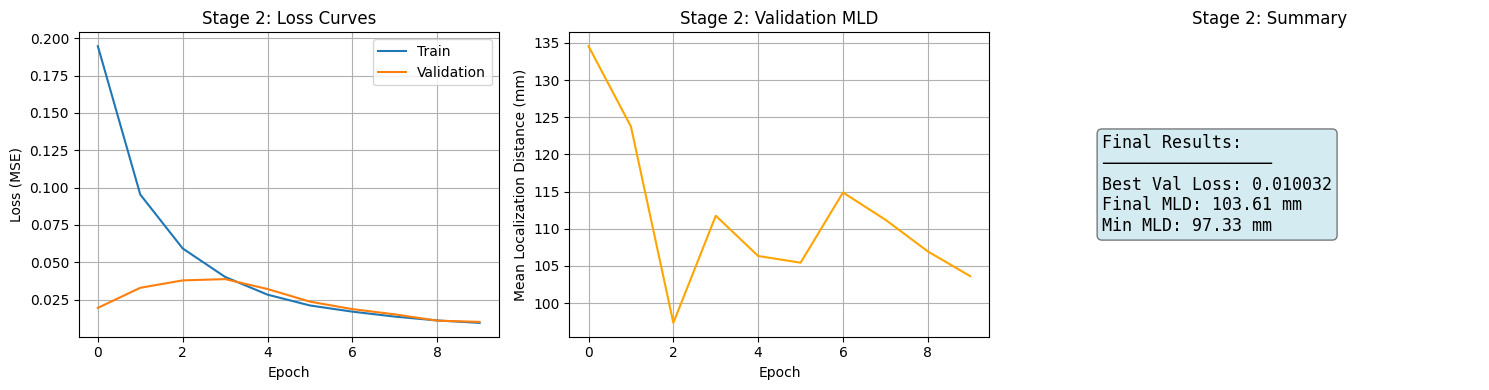

In [22]:
# Plot Stage 2 Results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history_s2['train_loss'], label='Train')
axes[0].plot(history_s2['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Stage 2: Loss Curves')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_s2['val_mld'], color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Localization Distance (mm)')
axes[1].set_title('Stage 2: Validation MLD')
axes[1].grid(True)

metrics_text = f"""Final Results:
─────────────────
Best Val Loss: {best_val_loss_s2:.6f}
Final MLD: {history_s2['val_mld'][-1]:.2f} mm
Min MLD: {min(history_s2['val_mld']):.2f} mm"""
axes[2].text(0.1, 0.5, metrics_text, transform=axes[2].transAxes, fontsize=12,
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[2].axis('off')
axes[2].set_title('Stage 2: Summary')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage2_results.png'), dpi=150)
plt.show()

---
# 🎯 Stage 3: Vertebrae Segmentation

Segment individual vertebrae from cropped regions.
- **Input**: Small crop around each vertebra (1mm spacing, 128×128×96)
- **Output**: Binary segmentation mask
- **Network**: U-Net 3D

In [23]:
# ============================================================
# Stage 3 Configuration
# ============================================================
class Stage3Config:
    image_size = (128, 128, 96)  # D, H, W
    spacing = (1.0, 1.0, 1.0)    # mm
    num_filters_base = 32
    num_levels = 4
    learning_rate = 1e-4

config3 = Stage3Config()
print("Stage 3 Config loaded")

Stage 3 Config loaded


In [24]:
# ============================================================
# Stage 3 Dataset
# ============================================================

class VertebraeSegmentationDataset(Dataset):
    def __init__(self, dataframe, config):
        self.config = config
        self.samples = []  # List of (image_path, mask_path, vertebra_label, centroid)
        
        for _, row in dataframe.iterrows():
            # Parse centroids using our parser
            centroids, direction = parse_centroid_json(row['centroid_json_path'])
            
            # Get all vertebrae (skip the _label keys)
            for vert_name, centroid in centroids.items():
                if '_label' in vert_name:
                    continue  # Skip label entries
                
                # Get the numeric label for this vertebra
                label_key = f'{vert_name}_label'
                vert_label = centroids.get(label_key, VERTEBRA_TO_LABEL.get(vert_name, 0))
                
                self.samples.append({
                    'image_path': row['image_path'],
                    'mask_path': row['mask_path'],
                    'vertebra': vert_name,
                    'vertebra_label': vert_label,  # Numeric label in mask
                    'centroid': centroid,  # [z_mm, y_mm, x_mm]
                    'name': f"{row['name']}_{vert_name}"
                })
        
        print(f"  Created {len(self.samples)} vertebra samples from {len(dataframe)} scans")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = load_image(sample['image_path'])
        image = resample_image(image, self.config.spacing)
        image_array = sitk.GetArrayFromImage(image)
        image_array = normalize_intensity(image_array)
        
        # Load mask
        mask = load_image(sample['mask_path'])
        mask = resample_image(mask, self.config.spacing, interpolator=sitk.sitkNearestNeighbor)
        mask_array = sitk.GetArrayFromImage(mask)
        
        # Get the numeric label for this vertebra (stored in mask)
        vert_label = sample['vertebra_label']
        
        # Create binary mask for this vertebra only
        binary_mask = (mask_array == vert_label).astype(np.float32)
        
        # Centroid is in world coordinates [z_mm, y_mm, x_mm]
        # Convert to voxel coordinates at Stage 3 spacing
        centroid_voxel = [
            sample['centroid'][i] / self.config.spacing[i]
            for i in range(3)
        ]
        
        image_crop = self._crop_around_center(image_array, centroid_voxel, self.config.image_size)
        mask_crop = self._crop_around_center(binary_mask, centroid_voxel, self.config.image_size)
        
        image_tensor = torch.from_numpy(image_crop).unsqueeze(0).float()
        mask_tensor = torch.from_numpy(mask_crop).unsqueeze(0).float()
        
        return {
            'image': image_tensor,
            'mask': mask_tensor,
            'name': sample['name']
        }
    
    def _crop_around_center(self, array, center, crop_size):
        result = np.zeros(crop_size, dtype=array.dtype)
        src_slices = []
        dst_slices = []
        
        for i in range(3):
            start = int(center[i] - crop_size[i] // 2)
            end = start + crop_size[i]
            
            src_start = max(0, start)
            src_end = min(array.shape[i], end)
            dst_start = src_start - start
            dst_end = dst_start + (src_end - src_start)
            
            src_slices.append(slice(src_start, src_end))
            dst_slices.append(slice(dst_start, dst_end))
        
        result[dst_slices[0], dst_slices[1], dst_slices[2]] = \
            array[src_slices[0], src_slices[1], src_slices[2]]
        
        return result

print("VertebraeSegmentationDataset defined")

VertebraeSegmentationDataset defined


In [25]:
# ============================================================
# Dice Loss for Segmentation
# ============================================================

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self.dice_weight = dice_weight
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        dice_loss = self.dice(pred, target)
        bce_loss = self.bce(pred, target)
        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss

print("Loss functions defined")

Loss functions defined


In [26]:
def compute_dice(pred, target, threshold=0.5):
    """Compute Dice coefficient."""
    pred_binary = (pred > threshold).float()
    
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum()
    
    if union == 0:
        return 1.0 if target.sum() == 0 else 0.0
    
    return (2 * intersection / union).item()

def validate_stage3(model, loader, criterion, device):
    """Validate Stage 3 with Dice score."""
    model.eval()
    total_loss = 0
    all_dice = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            images = batch['image'].to(device)
            targets = batch['mask'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Compute Dice
            probs = torch.sigmoid(outputs)
            for i in range(outputs.shape[0]):
                dice = compute_dice(probs[i], targets[i])
                all_dice.append(dice)
    
    mean_dice = np.mean(all_dice) if all_dice else 0
    return total_loss / len(loader), mean_dice

---
## 🧪 Pipeline Verification Test

Before training, let's verify all components work correctly with a single sample. Run this to ensure everything loads properly!

In [27]:
# ============================================================
# 🧪 PIPELINE VERIFICATION TEST
# ============================================================
# This tests all components before running the full training

print("=" * 70)
print("🧪 PIPELINE VERIFICATION - Testing all components")
print("=" * 70)

verification_passed = True
test_row = train_df.iloc[0]

# ─────────────────────────────────────────────────────────────
# Test 1: Basic file loading
# ─────────────────────────────────────────────────────────────
print("\n[1/6] Testing image loading...")
try:
    test_image = load_image(test_row['image_path'])
    print(f"  ✅ Image loaded: size={test_image.GetSize()}, spacing={tuple(f'{s:.2f}' for s in test_image.GetSpacing())}")
except Exception as e:
    print(f"  ❌ Failed: {e}")
    verification_passed = False

print("\n[2/6] Testing mask loading...")
try:
    test_mask = load_image(test_row['mask_path'])
    mask_array = sitk.GetArrayFromImage(test_mask)
    unique_labels = np.unique(mask_array[mask_array > 0])
    print(f"  ✅ Mask loaded: size={test_mask.GetSize()}")
    print(f"     Vertebra labels in mask: {unique_labels.tolist()}")
except Exception as e:
    print(f"  ❌ Failed: {e}")
    verification_passed = False

# ─────────────────────────────────────────────────────────────
# Test 2: Centroid JSON parsing
# ─────────────────────────────────────────────────────────────
print("\n[3/6] Testing centroid JSON parsing...")
try:
    centroids, direction = parse_centroid_json(test_row['centroid_json_path'])
    vert_names = [k for k in centroids.keys() if '_label' not in k]
    print(f"  ✅ Centroids parsed: {len(vert_names)} vertebrae")
    print(f"     Direction: {direction}")
    print(f"     Vertebrae found: {vert_names}")
    # Show one example
    if vert_names:
        ex = vert_names[0]
        ex_coords = centroids[ex]
        ex_label = centroids.get(f'{ex}_label', '?')
        print(f"     Example: {ex} (label={ex_label}) at Z={ex_coords[0]:.1f}, Y={ex_coords[1]:.1f}, X={ex_coords[2]:.1f} mm")
except Exception as e:
    print(f"  ❌ Failed: {e}")
    verification_passed = False

# ─────────────────────────────────────────────────────────────
# Test 3: Dataset classes
# ─────────────────────────────────────────────────────────────
print("\n[4/6] Testing Stage 1 Dataset (SpineLocalizationDataset)...")
try:
    test_ds1 = SpineLocalizationDataset(train_df.head(1), config1)
    sample1 = test_ds1[0]
    print(f"  ✅ Sample loaded!")
    print(f"     Image shape: {sample1['image'].shape}")
    print(f"     Heatmap shape: {sample1['heatmap'].shape}, max={sample1['heatmap'].max():.3f}")
except Exception as e:
    print(f"  ❌ Failed: {e}")
    verification_passed = False

print("\n[5/6] Testing Stage 2 Dataset (VertebraeLocalizationDataset)...")
try:
    test_ds2 = VertebraeLocalizationDataset(train_df.head(1), config2)
    sample2 = test_ds2[0]
    non_zero = (sample2['heatmap'].sum(dim=(1,2,3)) > 0).sum().item()
    print(f"  ✅ Sample loaded!")
    print(f"     Image shape: {sample2['image'].shape}")
    print(f"     Heatmaps: {sample2['heatmap'].shape} ({non_zero}/{config2.num_landmarks} non-zero)")
except Exception as e:
    print(f"  ❌ Failed: {e}")
    verification_passed = False

print("\n[6/6] Testing Stage 3 Dataset (VertebraeSegmentationDataset)...")
try:
    test_ds3 = VertebraeSegmentationDataset(train_df.head(1), config3)
    if len(test_ds3) > 0:
        sample3 = test_ds3[0]
        mask_pct = sample3['mask'].sum().item() / sample3['mask'].numel() * 100
        print(f"  ✅ Created {len(test_ds3)} vertebra crops!")
        print(f"     Image shape: {sample3['image'].shape}")
        print(f"     Mask shape: {sample3['mask'].shape}, coverage={mask_pct:.2f}%")
    else:
        print(f"  ⚠️ No samples created (check centroid labels vs mask labels)")
except Exception as e:
    print(f"  ❌ Failed: {e}")
    verification_passed = False

# ─────────────────────────────────────────────────────────────
# Summary
# ─────────────────────────────────────────────────────────────
print("\n" + "=" * 70)
if verification_passed:
    print("✅ ALL VERIFICATION TESTS PASSED!")
    print("   The pipeline is ready for training. Proceed to the next cells.")
else:
    print("❌ SOME TESTS FAILED!")
    print("   Please fix the issues above before proceeding.")
    print("   Common issues:")
    print("   - File paths in CSV are incorrect")
    print("   - Centroid JSON format doesn't match expected format")
    print("   - Mask labels don't match centroid labels")
print("=" * 70)

🧪 PIPELINE VERIFICATION - Testing all components

[1/6] Testing image loading...
  ✅ Image loaded: size=(161, 338, 61), spacing=('1.00', '1.00', '2.00')

[2/6] Testing mask loading...
  ✅ Mask loaded: size=(161, 338, 61)
     Vertebra labels in mask: [16, 17, 18, 19, 20, 21, 22, 23, 24]

[3/6] Testing centroid JSON parsing...
  ✅ Centroids parsed: 9 vertebrae
     Direction: ['P', 'I', 'R']
     Vertebrae found: ['T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4', 'L5']
     Example: T9 (label=16) at Z=31.9, Y=40.6, X=79.4 mm

[4/6] Testing Stage 1 Dataset (SpineLocalizationDataset)...
  ✅ Sample loaded!
     Image shape: torch.Size([1, 64, 64, 128])
     Heatmap shape: torch.Size([1, 64, 64, 128]), max=1.000

[5/6] Testing Stage 2 Dataset (VertebraeLocalizationDataset)...
  ✅ Sample loaded!
     Image shape: torch.Size([1, 96, 96, 128])
     Heatmaps: torch.Size([26, 96, 96, 128]) (6/26 non-zero)

[6/6] Testing Stage 3 Dataset (VertebraeSegmentationDataset)...
  Created 9 vertebra samp

---
# 🚀 Begin Training

If all verification tests passed above, proceed with training each stage.

In [28]:
# ============================================================
# Train Stage 3: Vertebrae Segmentation
# ============================================================

print("="*60)
print("STAGE 3: VERTEBRAE SEGMENTATION")
print("="*60)

# Create datasets
train_dataset_s3 = VertebraeSegmentationDataset(train_df, config3)
val_dataset_s3 = VertebraeSegmentationDataset(val_df, config3)

train_loader_s3 = DataLoader(train_dataset_s3, batch_size=BATCH_SIZE_STAGE3, shuffle=True, num_workers=2)
val_loader_s3 = DataLoader(val_dataset_s3, batch_size=BATCH_SIZE_STAGE3, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset_s3)} (vertebra crops)")
print(f"Validation samples: {len(val_dataset_s3)} (vertebra crops)")

# Create model (reuse UNet3D)
model_s3 = UNet3D(in_channels=1, out_channels=1, base_filters=config3.num_filters_base, num_levels=config3.num_levels)
model_s3 = nn.DataParallel(model_s3)
model_s3 = model_s3.to(device)

# Loss and optimizer
criterion_s3 = DiceBCELoss(dice_weight=0.5)
optimizer_s3 = optim.Adam(model_s3.parameters(), lr=config3.learning_rate)
scheduler_s3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_s3, mode='max', patience=5, factor=0.5)

# Training history
history_s3 = {'train_loss': [], 'val_loss': [], 'val_dice': []}

print(f"\nStarting training on {device}...")

STAGE 3: VERTEBRAE SEGMENTATION
  Created 95 vertebra samples from 10 scans
  Created 51 vertebra samples from 5 scans
Training samples: 95 (vertebra crops)
Validation samples: 51 (vertebra crops)

Starting training on cuda...


In [29]:
# ============================================================
# 🔍 DIAGNOSTIC CHECK - Run this BEFORE Stage 3 training
# ============================================================
print("Checking available training functions...")
print(f"✓ train_epoch exists: {'train_epoch' in dir()}")
print(f"✓ train_stage3_epoch exists: {'train_stage3_epoch' in dir()}")
print(f"✓ validate_stage3 exists: {'validate_stage3' in dir()}")

if 'train_stage3_epoch' not in dir():
    print("\n❌ ERROR: train_stage3_epoch is NOT defined!")
    print("   You need to re-run cell 18 (the one with Stage 3 training functions)")
    print("   OR restart the kernel and run all cells from the beginning")
else:
    print("\n✅ All Stage 3 functions are available!")

Checking available training functions...
✓ train_epoch exists: True
✓ train_stage3_epoch exists: True
✓ validate_stage3 exists: True

✅ All Stage 3 functions are available!


In [31]:
# Training loop for Stage 3
best_val_dice_s3 = 0
stage3_checkpoint = os.path.join(OUTPUT_DIR, 'stage3_best.pth')

for epoch in range(EPOCHS_STAGE3):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE3}")
    
    # Train
    train_loss = train_stage3_epoch(model_s3, train_loader_s3, optimizer_s3, criterion_s3, device, f"Train [{epoch+1}]")
    
    # Validate
    val_loss, val_dice = validate_stage3(model_s3, val_loader_s3, criterion_s3, device)
    
    # Update scheduler (based on Dice, want to maximize)
    scheduler_s3.step(val_dice)
    
    # Save history
    history_s3['train_loss'].append(train_loss)
    history_s3['val_loss'].append(val_loss)
    history_s3['val_dice'].append(val_dice)
    
    print(f"  Train Loss: {train_loss:.6f}")
    print(f"  Val Loss: {val_loss:.6f}")
    print(f"  Val Dice: {val_dice:.4f}")
    
    # Save best model
    if val_dice > best_val_dice_s3:
        best_val_dice_s3 = val_dice
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_s3.state_dict(),
            'optimizer_state_dict': optimizer_s3.state_dict(),
            'val_loss': val_loss,
            'val_dice': val_dice
        }, stage3_checkpoint)
        print(f"  ✓ Saved best model (Dice: {val_dice:.4f})")

print(f"\n✅ Stage 3 training complete!")
print(f"Best validation Dice: {best_val_dice_s3:.4f}")


Epoch 1/10


Train [1]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.798894
  Val Loss: 0.732649
  Val Dice: 0.0722
  ✓ Saved best model (Dice: 0.0722)

Epoch 2/10


Train [2]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.724601
  Val Loss: 0.706061
  Val Dice: 0.2265
  ✓ Saved best model (Dice: 0.2265)

Epoch 3/10


Train [3]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.701467
  Val Loss: 0.695247
  Val Dice: 0.2655
  ✓ Saved best model (Dice: 0.2655)

Epoch 4/10


Train [4]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.681583
  Val Loss: 0.726240
  Val Dice: 0.2003

Epoch 5/10


Train [5]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.666564
  Val Loss: 0.675520
  Val Dice: 0.3607
  ✓ Saved best model (Dice: 0.3607)

Epoch 6/10


Train [6]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.655260
  Val Loss: 0.651821
  Val Dice: 0.5074
  ✓ Saved best model (Dice: 0.5074)

Epoch 7/10


Train [7]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.641769
  Val Loss: 0.655205
  Val Dice: 0.4855

Epoch 8/10


Train [8]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.632740
  Val Loss: 0.660308
  Val Dice: 0.1820

Epoch 9/10


Train [9]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.621900
  Val Loss: 0.630580
  Val Dice: 0.5405
  ✓ Saved best model (Dice: 0.5405)

Epoch 10/10


Train [10]:   0%|          | 0/48 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.611178
  Val Loss: 0.639442
  Val Dice: 0.3795

✅ Stage 3 training complete!
Best validation Dice: 0.5405


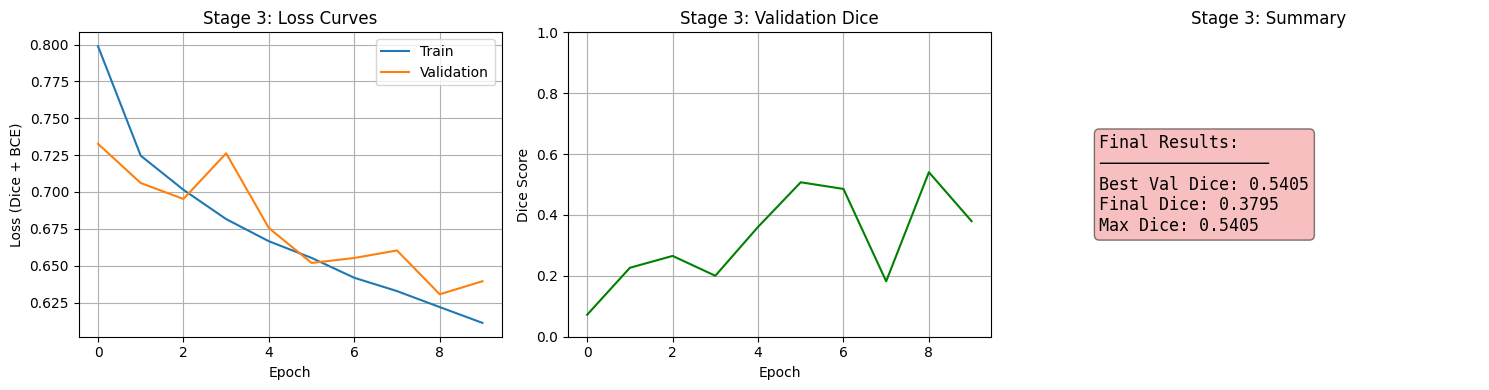

In [32]:
# Plot Stage 3 Results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history_s3['train_loss'], label='Train')
axes[0].plot(history_s3['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Dice + BCE)')
axes[0].set_title('Stage 3: Loss Curves')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_s3['val_dice'], color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Stage 3: Validation Dice')
axes[1].set_ylim([0, 1])
axes[1].grid(True)

metrics_text = f"""Final Results:
─────────────────
Best Val Dice: {best_val_dice_s3:.4f}
Final Dice: {history_s3['val_dice'][-1]:.4f}
Max Dice: {max(history_s3['val_dice']):.4f}"""
axes[2].text(0.1, 0.5, metrics_text, transform=axes[2].transAxes, fontsize=12,
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
axes[2].axis('off')
axes[2].set_title('Stage 3: Summary')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage3_results.png'), dpi=150)
plt.show()

---
# 📊 Final Summary

In [33]:
# ============================================================
# Final Summary
# ============================================================

print("="*70)
print("                     TRAINING SUMMARY")
print("="*70)

print("\n📍 STAGE 1: Spine Localization")
print(f"   • Best Val Loss: {best_val_loss_s1:.6f}")
print(f"   • Best Localization Error: {min(history_s1['val_error']):.2f} mm")
print(f"   • Checkpoint: {stage1_checkpoint}")

print("\n📍 STAGE 2: Vertebrae Localization")
print(f"   • Best Val Loss: {best_val_loss_s2:.6f}")
print(f"   • Best MLD: {min(history_s2['val_mld']):.2f} mm")
print(f"   • Checkpoint: {stage2_checkpoint}")

print("\n📍 STAGE 3: Vertebrae Segmentation")
print(f"   • Best Val Dice: {best_val_dice_s3:.4f}")
print(f"   • Checkpoint: {stage3_checkpoint}")

print("\n" + "="*70)
print("✅ All stages trained successfully!")
print("="*70)

                     TRAINING SUMMARY

📍 STAGE 1: Spine Localization
   • Best Val Loss: 0.001091
   • Best Localization Error: 148.68 mm
   • Checkpoint: /kaggle/working/outputs/stage1_best.pth

📍 STAGE 2: Vertebrae Localization
   • Best Val Loss: 0.010032
   • Best MLD: 97.33 mm
   • Checkpoint: /kaggle/working/outputs/stage2_best.pth

📍 STAGE 3: Vertebrae Segmentation
   • Best Val Dice: 0.5405
   • Checkpoint: /kaggle/working/outputs/stage3_best.pth

✅ All stages trained successfully!


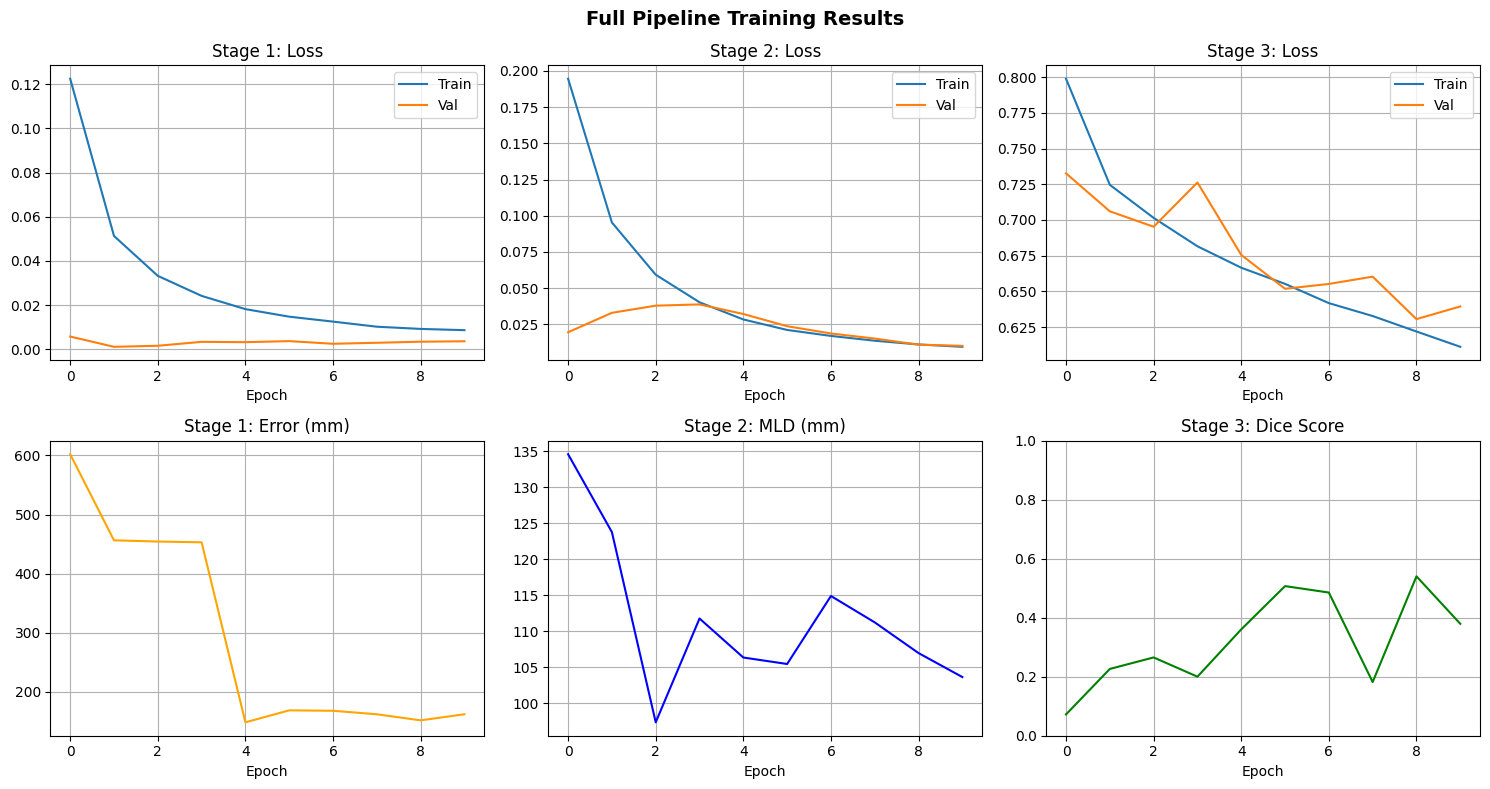


📊 Results saved to /kaggle/working/outputs/


In [34]:
# Combined visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Stage 1
axes[0, 0].plot(history_s1['train_loss'], label='Train')
axes[0, 0].plot(history_s1['val_loss'], label='Val')
axes[0, 0].set_title('Stage 1: Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[1, 0].plot(history_s1['val_error'], color='orange')
axes[1, 0].set_title('Stage 1: Error (mm)')
axes[1, 0].grid(True)

# Stage 2
axes[0, 1].plot(history_s2['train_loss'], label='Train')
axes[0, 1].plot(history_s2['val_loss'], label='Val')
axes[0, 1].set_title('Stage 2: Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 1].plot(history_s2['val_mld'], color='blue')
axes[1, 1].set_title('Stage 2: MLD (mm)')
axes[1, 1].grid(True)

# Stage 3
axes[0, 2].plot(history_s3['train_loss'], label='Train')
axes[0, 2].plot(history_s3['val_loss'], label='Val')
axes[0, 2].set_title('Stage 3: Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

axes[1, 2].plot(history_s3['val_dice'], color='green')
axes[1, 2].set_title('Stage 3: Dice Score')
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(True)

for ax in axes.flat:
    ax.set_xlabel('Epoch')

plt.suptitle('Full Pipeline Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'full_pipeline_results.png'), dpi=150)
plt.show()

print(f"\n📊 Results saved to {OUTPUT_DIR}/")

In [35]:
# List output files
print("\n📁 Output Files:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1024 / 1024
    print(f"   {f}: {size:.2f} MB")


📁 Output Files:
   full_pipeline_results.png: 0.18 MB
   stage1_best.pth: 64.22 MB
   stage1_results.png: 0.08 MB
   stage2_best.pth: 13.30 MB
   stage2_results.png: 0.10 MB
   stage3_best.pth: 64.22 MB
   stage3_results.png: 0.10 MB


---
# 🔮 Inference Example (Optional)

Run full pipeline on a test image.

Stage 1: Localizing spine...
  Spine centroid: [np.float64(0.0), np.float64(16.0), np.float64(8.0)]
Stage 2: Localizing vertebrae...
Stage 3: Segmenting vertebrae...
✅ Pipeline complete!


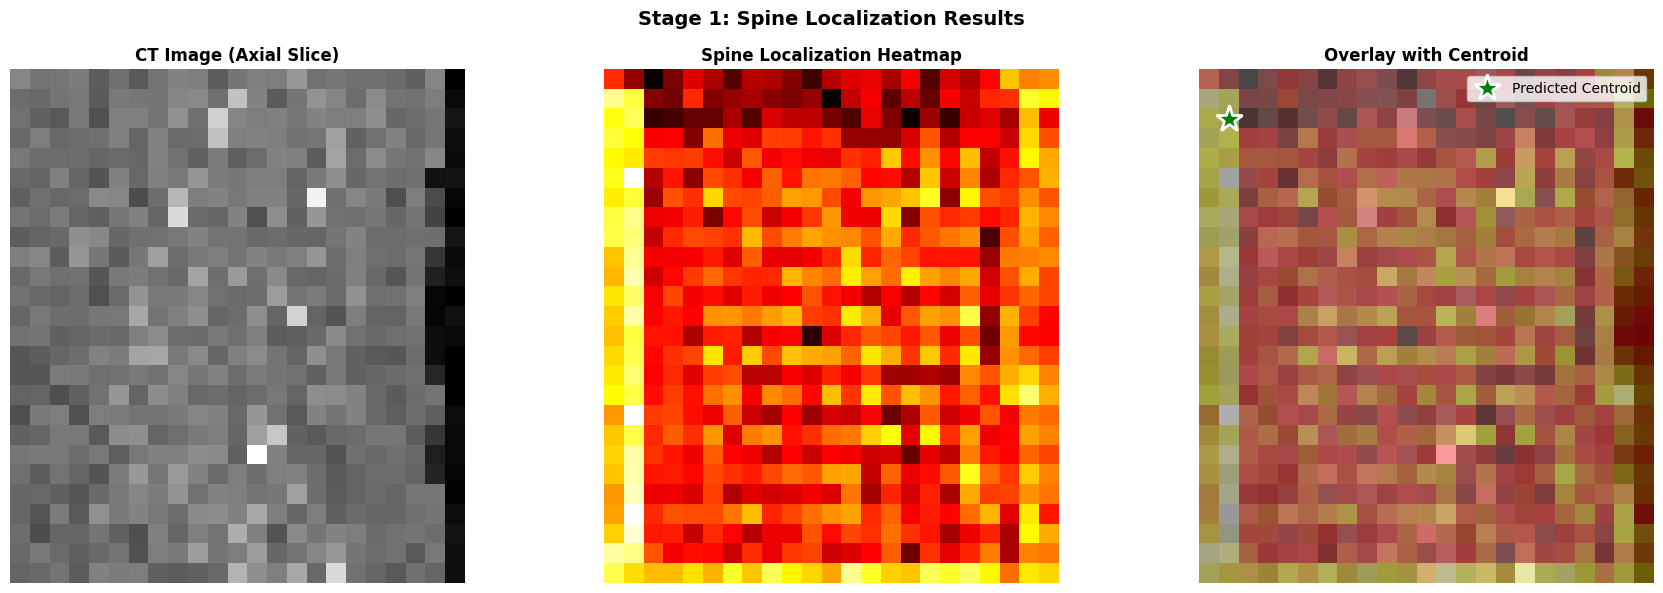


📊 Results Summary:
  Spine centroid (voxel): (np.int64(0), np.int64(2), np.int64(1))
  Spine centroid (mm): ['0.00', '16.00', '8.00']
  Heatmap shape: (23, 26, 23)
  Image shape: (23, 26, 23)


In [38]:
# ============================================================
# Full Pipeline Inference
# ============================================================
import matplotlib.pyplot as plt

def run_full_pipeline(image_path, model_s1, model_s2, model_s3, config1, config2, config3, device):
    """Run complete vertebrae segmentation pipeline."""
    
    # Load original image
    original_image = load_image(image_path)
    
    # ===== Stage 1: Spine Localization =====
    print("Stage 1: Localizing spine...")
    model_s1.eval()
    
    image_s1 = resample_image(original_image, config1.spacing)
    array_s1 = normalize_intensity(sitk.GetArrayFromImage(image_s1))
    # Resize to target
    # (simplified - would need proper resize function)
    
    with torch.no_grad():
        input_s1 = torch.from_numpy(array_s1).unsqueeze(0).unsqueeze(0).float().to(device)
        heatmap_s1 = model_s1(input_s1)[0, 0].cpu().numpy()
    
    spine_centroid = np.unravel_index(np.argmax(heatmap_s1), heatmap_s1.shape)
    spine_centroid_mm = [c * s for c, s in zip(spine_centroid, config1.spacing)]
    print(f"  Spine centroid: {spine_centroid_mm}")
    
    # ===== Stage 2: Vertebrae Localization =====
    print("Stage 2: Localizing vertebrae...")
    # ... (would crop around spine and run SCNet)
    
    # ===== Stage 3: Vertebrae Segmentation =====
    print("Stage 3: Segmenting vertebrae...")
    # ... (would crop around each vertebra and segment)
    
    print("✅ Pipeline complete!")
    
    # Return results including intermediate data for visualization
    return {
        "spine_centroid": spine_centroid_mm,
        "spine_centroid_voxel": spine_centroid,
        "heatmap": heatmap_s1,
        "image_array": array_s1
    }

# Run inference on a test image
test_image = "/kaggle/input/verse-19-3d-images/dataset-verse19validation/rawdata/sub-verse010/sub-verse010_ct.nii"
results = run_full_pipeline(test_image, model_s1, model_s2, model_s3, config1, config2, config3, device)

# ============================================================
# Visualize Results
# ============================================================

# Get results
heatmap_s1 = results['heatmap']
array_s1 = results['image_array']
spine_centroid = results['spine_centroid_voxel']
spine_centroid_mm = results['spine_centroid']

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Get middle axial slice
mid_slice = array_s1.shape[0] // 2

# 1. Original CT slice
axes[0].imshow(array_s1[mid_slice, :, :], cmap='gray')
axes[0].set_title('CT Image (Axial Slice)', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. Stage 1 Heatmap
axes[1].imshow(heatmap_s1[mid_slice, :, :], cmap='hot')
axes[1].set_title('Spine Localization Heatmap', fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. Overlay with predicted centroid
axes[2].imshow(array_s1[mid_slice, :, :], cmap='gray')
axes[2].imshow(heatmap_s1[mid_slice, :, :], cmap='hot', alpha=0.4)
axes[2].plot(spine_centroid[2], spine_centroid[1], 'g*', markersize=20, 
             markeredgewidth=2, markeredgecolor='white', label='Predicted Centroid')
axes[2].set_title('Overlay with Centroid', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].axis('off')

plt.suptitle('Stage 1: Spine Localization Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Results Summary:")
print(f"  Spine centroid (voxel): {spine_centroid}")
print(f"  Spine centroid (mm): {[f'{x:.2f}' for x in spine_centroid_mm]}")
print(f"  Heatmap shape: {heatmap_s1.shape}")
print(f"  Image shape: {array_s1.shape}")

---
## 📝 Notes

### Dataset CSV Format
Your CSV should have these columns:
- `name`: Unique identifier (e.g., "sub-verse001")
- `type`: "train" or "valid" (optional, we use K-Fold)
- `image_path`: Path to CT image (.nii.gz)
- `mask_path`: Path to segmentation mask (.nii.gz)
- `centroid_json_path`: Path to JSON with vertebra centroids

### Centroid JSON Format (VerSe Style)
```json
[
    {"direction": ["P", "I", "R"]},
    {"label": 17, "X": 94.8, "Y": 46.1, "Z": 19.1},
    {"label": 18, "X": 90.3, "Y": 71.7, "Z": 18.6},
    {"label": 19, "X": 85.2, "Y": 100.8, "Z": 18.6}
]
```

**Label mapping**: C1=1...C7=7, T1=8...T12=19, L1=20...L5=24, L6=25, S1=26

### Quick Test Mode
Set `QUICK_TEST_SAMPLES = 5` (or any small number) at the top to test the pipeline quickly before running full training.

### Kaggle Tips
1. **GPU**: Use P100 or T4 accelerator
2. **Memory**: If OOM, reduce batch size
3. **Persistence**: Enable "Save output"
4. **Time**: Quick test ~10 min, Full training ~6-12 hours